# WideResNet in Chainer

### Install Chainer

In [0]:
!curl https://colab.chainer.org/install | sh -

In [0]:
import chainer as ch
import numpy as np
import chainer.functions as F
import chainer.links as L
from chainer import Chain, Sequential
from chainer.training import extensions as E

ch.config.autotune = True # Enable autotuner of cuDNN

###Set the hyperparameters

In [0]:
BATCH_SIZE = 128
DEPTH = 16
WIDTH_FACTOR = 4
WEIGHT_DECAY = 0.0005
LABEL_SMOOTHING = 0.1

### Define the model

In [0]:
class BasicUnit(Chain):
    def __init__(self, channels):
        super(BasicUnit, self).__init__()
        w = ch.initializers.HeNormal()
        
        with self.init_scope():
            self.block = Sequential(
                L.BatchNormalization(channels),
                F.relu,
                L.Convolution2D(in_channels=channels, out_channels=channels, ksize=3, stride=1, pad=1, nobias=True, initialW=w),
                L.BatchNormalization(channels),
                F.relu,
                L.Convolution2D(in_channels=channels, out_channels=channels, ksize=3, stride=1, pad=1, nobias=True, initialW=w)
            )

    def forward(self, x):
        return x + self.block(x)


class DownsampleUnit(Chain):
    def __init__(self, in_channels, out_channels, stride):
        super(DownsampleUnit, self).__init__()
        w = ch.initializers.HeNormal()
        
        with self.init_scope():
            self.batchNorm = L.BatchNormalization(in_channels)
            self.block = Sequential(
                L.Convolution2D(in_channels=in_channels, out_channels=out_channels, ksize=3, stride=stride, pad=1, nobias=True, initialW=w),
                L.BatchNormalization(out_channels),
                F.relu,
                L.Convolution2D(in_channels=out_channels, out_channels=out_channels, ksize=3, stride=1, pad=1, nobias=True, initialW=w)
            )
            self.downsample = L.Convolution2D(in_channels=in_channels, out_channels=out_channels, ksize=1, stride=stride, pad=0, nobias=True, initialW=w)

    def forward(self, x):
        x = self.batchNorm(F.relu(x))
        return self.downsample(x) + self.block(x)


class Block(Sequential):
    def __init__(self, in_channels, out_channels, stride, depth):
        super(Block, self).__init__(
            DownsampleUnit(in_channels, out_channels, stride),
            BasicUnit(out_channels).repeat(depth)
        )
    

class WideResNet(Sequential):
    def __init__(self, depth, width_factor, in_channels, labels):
        self.filters = [16, 1 * 16 * width_factor, 2 * 16 * width_factor, 4 * 16 * width_factor]
        self.block_depth = (depth - 4) // (3 * 2)
        w = ch.initializers.HeNormal()

        super(WideResNet, self).__init__(
            L.Convolution2D(in_channels=in_channels, out_channels=self.filters[0], ksize=3, stride=1, pad=1, nobias=True, initialW=w),
            Block(self.filters[0], self.filters[1], 1, self.block_depth),
            Block(self.filters[1], self.filters[2], 2, self.block_depth),
            Block(self.filters[2], self.filters[3], 2, self.block_depth),
            L.BatchNormalization(self.filters[3]),
            F.relu,
            lambda x: F.average_pooling_2d(x, ksize=x.shape[2:]).reshape(-1, self.filters[3]),
            L.Linear(in_size=self.filters[3], out_size=labels, initialW=w)
        )
        

model = WideResNet(DEPTH, WIDTH_FACTOR, in_channels=3, labels=10)

### Create crossentropy loss with label smoothing

In [0]:
def smoothed_crossentropy(logits, labels):
    log_prob = F.log_softmax(logits)
    loss = - (1-LABEL_SMOOTHING) * F.mean(log_prob[np.arange(logits.shape[0]), labels]) - LABEL_SMOOTHING * F.mean(log_prob)
    
    return loss


model = L.Classifier(model, lossfun=smoothed_crossentropy).to_gpu(0)

### Download CIFAR10 dataset

In [0]:
train, test = ch.datasets.get_cifar10() # download
valid, train = ch.datasets.split_dataset_random(train, 5000, seed=0)

train size: 45000, valid size: 5000, test size: 10000
data shape: (3, 32, 32)
data mean: [0.4914782  0.4822848  0.44654745], std: [0.24709967 0.24346308 0.26158434], min: 0.000, max: 1.000


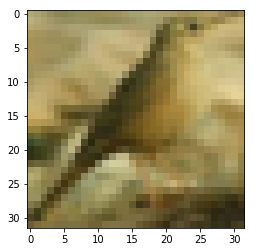

In [7]:
print(f"train size: {len(train)}, valid size: {len(valid)}, test size: {len(test)}")

im, label = train[0]
images = np.array([im for im, _ in train])
CIFAR_C, CIFAR_H, CIFAR_W = im.shape
CIFAR_MEAN = images.mean((0,2,3))
CIFAR_STD = images.std((0,2,3))

print(f"data shape: {CIFAR_C, CIFAR_H, CIFAR_W}")
print(f"data mean: {CIFAR_MEAN}, std: {CIFAR_STD}, min: {images.min():.3f}, max: {images.max():.3f}")     

import matplotlib.pyplot as plt
plt.imshow(np.transpose(im, axes=(1,2,0)))
plt.show()

### Define dataset augmentations

In [0]:
def cutout(image, size=16, p=0.5):
    if np.random.uniform() > p: return image
    half_size = size // 2

    left = np.random.randint(-half_size, CIFAR_W - half_size)
    top = np.random.randint(-half_size, CIFAR_H - half_size)
    right = min(CIFAR_W, left + size)
    bottom = min(CIFAR_H, top + size)

    image[:, max(0,left):right, max(0,top):bottom] = 0
    return image

def horizontal_flip(image, p=0.5):
    if np.random.uniform() > p: return image
    return np.fliplr(image)

# does the same as padding by 4 and then randomly cropping
def translate(image, amount=4):
    clamp = lambda n: max(0, min(n, CIFAR_H))
    top, left = np.random.randint(-amount, amount), np.random.randint(-amount, amount)

    translated = np.zeros((CIFAR_C, CIFAR_H, CIFAR_W), dtype=np.float32)
    translated[:, clamp(-top):clamp(-top + CIFAR_H), clamp(-left):clamp(-left + CIFAR_W)] = image[:, clamp(top):clamp(top + CIFAR_H), clamp(left):clamp(left + CIFAR_W)]

    return translated

In [0]:
def augment(input, train: bool):
    img, label = input
    img = img.copy()
    
    img -= CIFAR_MEAN[:, None, None]
    img /= CIFAR_STD[:, None, None]

    if train:
        img = translate(horizontal_flip(cutout(img)))
    
    return img, label


train = ch.datasets.TransformDataset(train, lambda im: augment(im, train=True))
valid = ch.datasets.TransformDataset(valid, lambda im: augment(im, train=False))
test = ch.datasets.TransformDataset(valid, lambda im: augment(im, train=False))

### Define iterators

In [0]:
train_iter = ch.iterators.MultiprocessIterator(train, BATCH_SIZE, repeat=True, shuffle=True)
eval_iter = ch.iterators.MultiprocessIterator(valid, BATCH_SIZE, repeat=False, shuffle=False)

### Define optimizer

In [0]:
optimizer = ch.optimizers.NesterovAG(lr=0.1)
optimizer.setup(model)
optimizer.add_hook(ch.optimizer.WeightDecay(WEIGHT_DECAY))

### Define updater and trainer

In [0]:
updater = ch.training.StandardUpdater(train_iter, optimizer, device=0)
trainer = ch.training.Trainer(updater, (200, 'epoch'), extensions=[
    E.Evaluator(eval_iter, model, device=0),
    E.observe_lr(),
    E.LogReport(),
    E.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'),
    E.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'),
    E.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time', 'lr'])
])
trainer.extend(E.MultistepShift('lr', gamma=0.2, step_value=[60, 120, 160], init=0.1, optimizer=optimizer), trigger=(1, 'epoch'))

### Start training

In [0]:
trainer.run()